### VGG16+UNET

1. Now we will try UNET with VGG16 as Back bone network.
2. We consider VGG16 with pre-trained imagenet weights as a backbone and will fine tune rest of the network
3. Here I am using "segmentation_models" package so that it will have network models with pre-trained weights for faster and better convergence

In [1]:
#Importing the necessary modules 
import tensorflow as tf
SM_FRAMEWORK=tf.keras
# import segmentation_models as sm #https://segmentation-models.readthedocs.io/en/latest/tutorial.html
# sm.set_framework('tf.keras')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import cv2
from tqdm import tqdm_notebook as tqdm 
#from tqdm.notebook import tqdm
import joblib 
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from imageio import imread
import imageio
import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import datetime

In [2]:
f"Tensorflow version = {tf.__version__}"

'Tensorflow version = 2.5.0'

In [3]:
backbone_model = 'vgg16'
LR = 0.0001
input_shape=(512,512,3)
n_class = 1  
activation = 'sigmoid'
encoder_weights = 'imagenet'
encoder_freeze = True
inputs = Input(shape=input_shape)

In [4]:
class segment_unet(Model):
    def __init__(self,backbone_model,n_class,activation,encoder_weights,encoder_freeze):
        
        super(segment_unet, self).__init__()    
        self.backbone_model = backbone_model
        #self.input_shape = input_shape
        self.n_class = n_class
        self.activation =activation
        self.encoder_weights =encoder_weights
        self.encoder_freeze =encoder_freeze
        #Ref: https://segmentation-models.readthedocs.io/en/latest/tutorial.html
        self.seg_model = sm.Unet(backbone_model, 
                            classes=n_class, 
                            encoder_weights=encoder_weights,
                            activation=activation,
                            encoder_freeze=encoder_freeze,
                            input_shape=input_shape)
        
    def call(self,inputs):
        return self.seg_model(inputs)
        
        

In [5]:
outputs = segment_unet(backbone_model=backbone_model,
                                n_class=n_class,
                                activation=activation,
                                encoder_weights=encoder_weights,
                                encoder_freeze=encoder_freeze)(inputs)

model_vgg16_unet = Model(inputs,outputs)

In [6]:
model_vgg16_unet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
segment_unet (segment_unet)  (None, 512, 512, 1)       23752273  
Total params: 23,752,273
Trainable params: 9,033,553
Non-trainable params: 14,718,720
_________________________________________________________________


In [7]:
optim = keras.optimizers.Adam(LR)
metrics = [tfa.metrics.F1Score(num_classes=1,average="micro",threshold=0.5)]
model_vgg16_unet.compile(optim, 'binary_crossentropy',metrics)

In [4]:
train_data=pd.read_csv('train_data.csv')
test_data=pd.read_csv('test_data.csv')
val_data=pd.read_csv('val_data.csv')

In [5]:
print(test_data)

      Unnamed: 0                                                  X  \
0              0  D:/collage/Sem 4/Intership/Image-forgery-local...   
1              1  D:/collage/Sem 4/Intership/Image-forgery-local...   
2              2  D:/collage/Sem 4/Intership/Image-forgery-local...   
3              3  D:/collage/Sem 4/Intership/Image-forgery-local...   
4              4  D:/collage/Sem 4/Intership/Image-forgery-local...   
...          ...                                                ...   
1248        1248  D:/collage/Sem 4/Intership/Image-forgery-local...   
1249        1249  D:/collage/Sem 4/Intership/Image-forgery-local...   
1250        1250  D:/collage/Sem 4/Intership/Image-forgery-local...   
1251        1251  D:/collage/Sem 4/Intership/Image-forgery-local...   
1252        1252  D:/collage/Sem 4/Intership/Image-forgery-local...   

                                                      y  
0                                      default.mask.png  
1     D:/collage/Sem 4/Intershi

In [6]:
batch_size = 8
def train_gen_fk():
    data = train_data
    data_reduced = data[data['y']!='default.mask.png']
    while True:
        for start in range(0, data_reduced.shape[0], batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, data_reduced.shape[0])
            x_data_batch = data_reduced.iloc[start:end]
            
            for index,row in x_data_batch.iterrows():
                image = load_img(row['X'])
                image = img_to_array(image)
                mask = imread(row['y'])
                mask= img_to_array(mask,dtype=np.uint8)
                x_batch.append(image)
                y_batch.append(mask)
            
            x_batch = np.array(x_batch).reshape(-1, 512, 512, 3)/255
            y_batch = np.array(y_batch)/255

            yield x_batch, y_batch

def val_gen_fk():
    data = val_data
    data_reduced = data[data['y']!='default.mask.png']
    while True:
        for start in range(0, data_reduced.shape[0], batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, data_reduced.shape[0])
            x_data_batch = data_reduced.iloc[start:end]
            
            for index,row in x_data_batch.iterrows():
                image = load_img(row['X'])
                image = img_to_array(image)
                mask = imread(row['y'])
                mask= img_to_array(mask,dtype=np.uint8)
                x_batch.append(image)
                y_batch.append(mask)
            
            x_batch = np.array(x_batch).reshape(-1, 512, 512, 3)/255
            y_batch = np.array(y_batch)/255

            yield x_batch, y_batch

def test_gen_fk():
    data = test_data
    data_reduced = data[data['y']!='default.mask.png']
    while True:
        for start in range(0, data_reduced.shape[0], batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, data_reduced.shape[0])
            x_data_batch = data_reduced.iloc[start:end]
            
            for index,row in x_data_batch.iterrows():
                image = load_img(row['X'])
                image = img_to_array(image)
                mask = imread(row['y'])
                mask= img_to_array(mask,dtype=np.uint8)
                x_batch.append(image)
                y_batch.append(mask)
            
            x_batch = np.array(x_batch).reshape(-1, 512, 512, 3)/255
            y_batch = np.array(y_batch)/255

            yield x_batch, y_batch

In [7]:
train_data_gen = tf.data.Dataset.from_generator(train_gen_fk, output_types=(tf.float32, tf.int32),output_shapes=((batch_size,512,512,3), (batch_size,512,512,1)))
val_data_gen = tf.data.Dataset.from_generator(val_gen_fk, output_types=(tf.float32, tf.int32),output_shapes=((batch_size,512,512,3), (batch_size,512,512,1)))
test_data_gen = tf.data.Dataset.from_generator(test_gen_fk, output_types=(tf.float32, tf.int32),output_shapes=((batch_size,512,512,3), (batch_size,512,512,1)))

In [8]:
print(train_data_gen)

<FlatMapDataset shapes: ((8, 512, 512, 3), (8, 512, 512, 1)), types: (tf.float32, tf.int32)>


In [9]:
print(f"Batch size and shape of input generator {list(train_data_gen.take(4).as_numpy_iterator())[0][0].shape}")
print(f"Batch size and shape of output generator {list(train_data_gen.take(4).as_numpy_iterator())[0][1].shape}")

Batch size and shape of input generator (8, 512, 512, 3)
Batch size and shape of output generator (8, 512, 512, 1)


In [10]:
checkPoint_path = "model_checkpoints/model_pre_trained_vgg16unet_tf_version2/"

filepath= checkPoint_path+"weights-improvement-{epoch:02d}-{val_f1_score:.2f}.ckpt"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_f1_score', verbose=1,save_best_only=True,save_weights_only=True, mode='max')

tensorboard_log_dir = "model_pre_trained_vgg16unet" 
tensorboard_path = os.path.join("logs",tensorboard_log_dir)

tensorboard_callback = TensorBoard(log_dir=tensorboard_path, histogram_freq=3)

callbacks_list = [
    checkpoint,
    tensorboard_callback]

In [16]:
batch_size = 8
max_epochs = 10

history = model_vgg16_unet.fit(train_data_gen,
                    steps_per_epoch=64,
                    epochs=max_epochs,
                    validation_data=val_data_gen,
                    validation_steps=64,
                    callbacks=callbacks_list
                             )


Epoch 1/10


UnknownError:  KeyError: 'y'
Traceback (most recent call last):

  File "C:\Users\siree\anaconda3\envs\deeplearning\lib\site-packages\pandas\core\indexes\base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)

  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc

  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc

  File "pandas\_libs\hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item

  File "pandas\_libs\hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item

KeyError: 'y'


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "C:\Users\siree\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\Users\siree\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\siree\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 961, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "<ipython-input-12-d6d75c39373a>", line 4, in train_gen_fk
    data_reduced = data[data['y']!='default.mask.png']

  File "C:\Users\siree\anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py", line 3024, in __getitem__
    indexer = self.columns.get_loc(key)

  File "C:\Users\siree\anaconda3\envs\deeplearning\lib\site-packages\pandas\core\indexes\base.py", line 3082, in get_loc
    raise KeyError(key) from err

KeyError: 'y'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_3913]

Function call stack:
train_function


In [11]:
%load_ext tensorboard

In [12]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 23688), started 1 day, 20:17:21 ago. (Use '!kill 23688' to kill it.)

In [13]:
model= keras.models.load_model("trained_models/model_vgg16_unet_tf_version2")

In [17]:
model_vgg16_unet.save('trained_models/model_vgg16_unet_tf_version2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: trained_models/model_vgg16_unet_tf_version2\assets


In [14]:
logloss_on_testdata,f1_score_on_testdata=model.evaluate_generator(test_data_gen,steps=16,verbose=1)
print(f'Logloss on TEST data {logloss_on_testdata}')
print(f'F1_Score on TEST data {f1_score_on_testdata}')

In [14]:
def print_results(model_path,split_data_df,show_images=10):
    """This function prints the input image,its ground truth mask along with predicted mask
        model_path : Takes the path of trianed model
        split_data_df : Takes the pd.DataFrame object that should contain image path and mask path in X and Y named columns
        show_images : number of random images that should sampled from "split_data_df"
    """
    samples = split_data_df.sample(n=show_images)
    model = tf.keras.models.load_model(model_path,custom_objects={'F1Score':tfa.metrics.F1Score(num_classes=1,average="micro",threshold=0.5) })
    input_img = []
    input_img_array = []
    mask_array = []
    GT_mask = []
    Predicted_mask = []
    for index,row in samples.iterrows():
        image = load_img(row['X'])
        image_arr = img_to_array(image)
        image_arr=np.array(image_arr).reshape(-1, 512, 512, 3)/255
        #tf_image = tf.data.Dataset.from_tensor_slices(image_arr)
        input_img_array.append(image_arr)
        mask = imread(row['y'])
        mask_arr= img_to_array(mask,dtype=np.uint8)
        mask_array.append(mask_arr/255)
        output = model.predict(image_arr).reshape(512,512)
        input_img.append(image)
        GT_mask.append(mask)
        Predicted_mask.append(output)
    
    for i in range(show_images):
        fig, ax = plt.subplots(1,3,figsize=(10, 10))   
        ax[0].imshow(input_img[i])
        ax[0].set_title("Input Image")
        ax[1].imshow(Predicted_mask[i])
        ax[1].set_title("Predicted Mask")
        ax[2].imshow(GT_mask[i])
        ax[2].set_title("Groud Truth Mask")
        

(512, 512, 3)


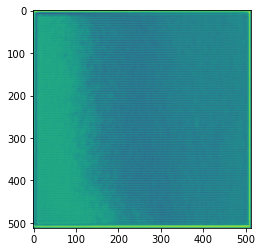

In [22]:

image=load_img("D:/collage/Sem 4/Intership/dataset-dist/phase-01/training/fake/152681a0017a5fded699c43cd6df97d1.png")
image_arr = img_to_array(image)
image_arr.resize((512,512,3))
print(np.array(image_arr).shape)
image_arr=np.array(image_arr).reshape(-1, 512, 512, 3)/255
output1=model.predict(image_arr).reshape(512,512)
plt.imshow(output1)


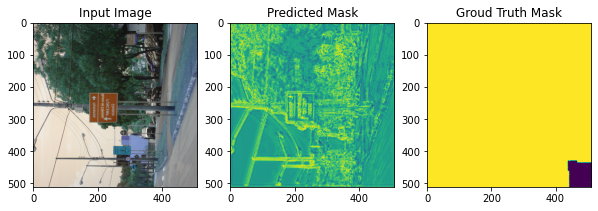

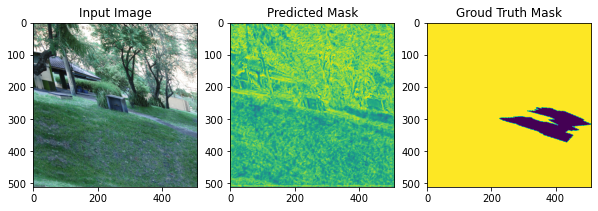

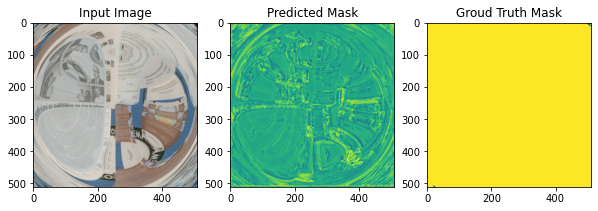

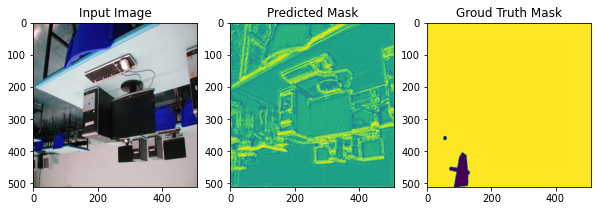

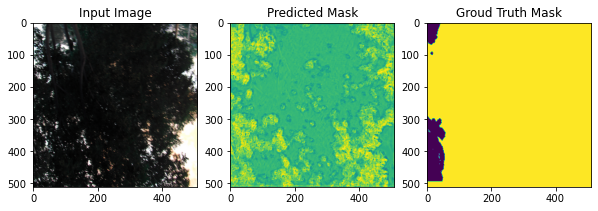

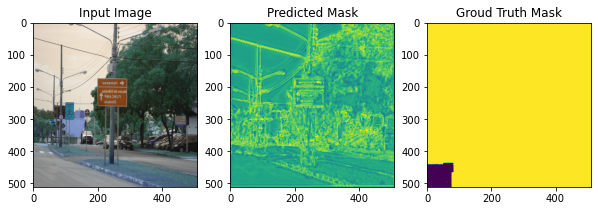

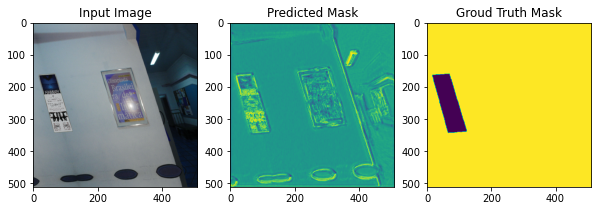

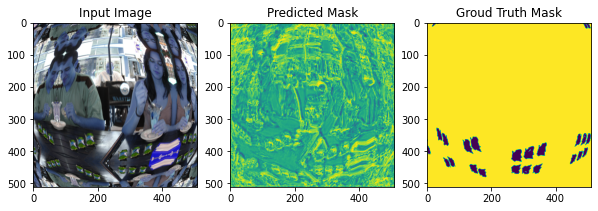

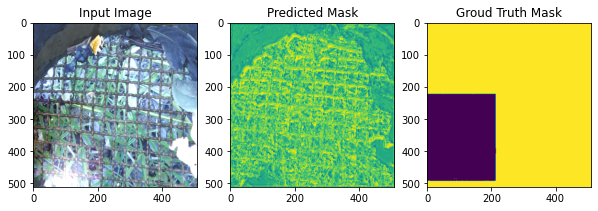

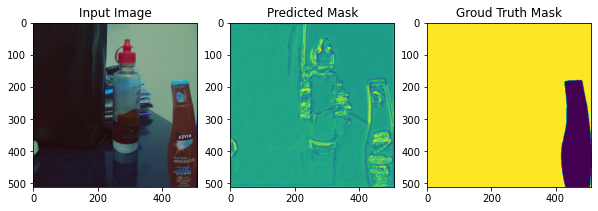

In [32]:
print_results(model_path='trained_models/model_vgg16_unet_tf_version2',
              split_data_df =test_data[test_data['y']!='default.mask.png'],show_images=5)